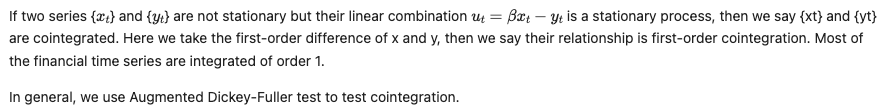

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [3]:
from twelvedata import TDClient
 
td = TDClient(apikey="93082025cf5e47fcb9e276316b21e33e")

stocks = ['FNGU','SOXL']
end  = '2024-2-13'
fee = 0.001
window = 252 #252
t_threshold = -2.5
overweight = 1
underweight = 1 - overweight
neutralweight = 1/2


data = pd.DataFrame()
returns = pd.DataFrame()

for stock in stocks:
    ts = td.time_series(
    symbol= stock,
    interval="1day",
    outputsize= 1000 - (252 - window),
    )
    prices = ts.as_pandas().iloc[::-1]
    data[stock] = prices['close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True)-1,0)

In [4]:
gross_returns = np.array([])
excess_returns = np.array([])
t_s = np.array([])
stock1 = stocks[0]
stock2 = stocks[1]

for t in range(window, len(data)-1):
    #defining unit root function for optimization: fair value for stock2 = a + b*stock1, if fair value > price, long 
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t]) #rolling window, lenth = window
        fair_value = a + b*data[stock1][t-window:t]
        spread = np.array(fair_value - data[stock2][t-window:t]) #model - real
        spread_diff = spread[1:] - spread[:-1] #test unit root for spread
        reg = sm.OLS(spread_diff, spread[:-1]) #dicker fuller
        res = reg.fit()
        return res.params[0]/res.bse[0] #coefficient/standard error, DF t-stats
    
    res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method = "Nelder-Mead")
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    fair_value = a_opt + b_opt*data[stock1][t]
    
    if t == window: #start trading
        old_signal = 0
    if t_opt > t_threshold: #not significant, not cointergrated then neutral view 50/50 portfolio
        signal = 0
        gross_return = neutralweight * returns[stock2][t+1] + neutralweight * returns[stock1][t+1]
    
    else:
        signal = np.sign(fair_value - data[stock2][t]) #For stock2, if fair value - price >0,1; if 0,0; if <0,-1
        
        if signal == 1:
            gross_return = overweight * returns[stock2][t+1] + underweight * returns[stock1][t+1]
        elif signal == 0:
            gross_return = neutralweight * returns[stock2][t+1] + neutralweight * returns[stock1][t+1]
        else:
            gross_return = underweight * returns[stock2][t+1] + overweight * returns[stock1][t+1]
    
    benchmark_return = neutralweight * returns[stock2][t+1] + neutralweight * returns[stock1][t+1]
    gross_returns = np.append(gross_returns, gross_return)
    excess_return = gross_return - benchmark_return
    excess_returns = np.append(excess_returns, excess_return)
    t_s = np.append(t_s, t_opt)
    
    print('Signal on date ' + str(data.index[t+1]) + ': ' + str(signal))
    if signal == 0:
        print('50/50 portfolio')
    elif signal == 1:
        print('Overweight ' + stock2 + ' Underweight  ' + stock1)
    else:
        print('Overweight ' + stock1 + ' Underweight  ' + stock2)
    
    print('gross daily return on the next date: ' + str(round(gross_return*100,2))+'%')
    print('excess daily return: ' + str(round(gross_return * 100 - benchmark_return * 100,2))+ '%')
    print('cumulative gross return so far: ' + str(round(np.prod(1+gross_returns)*100 - 100,2))+'%')
    print('cumulative excess return so far: ' + str(round(np.prod(1+excess_returns)*100 - 100,2))+'%')
    print(' ')
    old_signal = signal #for calculating fees

Signal on date 2021-02-25 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 0.06%
excess daily return: -3.41%
cumulative gross return so far: 0.06%
cumulative excess return so far: -3.41%
 
Signal on date 2021-02-26 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 9.94%
excess daily return: 0.59%
cumulative gross return so far: 10.0%
cumulative excess return so far: -2.84%
 
Signal on date 2021-03-01 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -5.94%
excess daily return: 1.74%
cumulative gross return so far: 3.47%
cumulative excess return so far: -1.15%
 
Signal on date 2021-03-02 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -10.85%
excess daily return: -0.83%
cumulative gross return so far: -7.75%
cumulative excess return so far: -1.98%
 
Signal on date 2021-03-03 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return o

Signal on date 2021-05-03 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: -4.61%
excess daily return: 0.42%
cumulative gross return so far: -4.75%
cumulative excess return so far: 2.99%
 
Signal on date 2021-05-04 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 1.71%
excess daily return: 1.83%
cumulative gross return so far: -3.12%
cumulative excess return so far: 4.88%
 
Signal on date 2021-05-05 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 1.12%
excess daily return: -0.67%
cumulative gross return so far: -2.04%
cumulative excess return so far: 4.17%
 
Signal on date 2021-05-06 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 1.0%
excess daily return: -1.66%
cumulative gross return so far: -1.06%
cumulative excess return so far: 2.44%
 
Signal on date 2021-05-07 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the

Signal on date 2021-06-25 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 7.35%
excess daily return: 1.19%
cumulative gross return so far: 24.75%
cumulative excess return so far: 2.13%
 
Signal on date 2021-06-28 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 2.27%
excess daily return: 0.85%
cumulative gross return so far: 27.58%
cumulative excess return so far: 3.0%
 
Signal on date 2021-06-29 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: -0.22%
excess daily return: 0.76%
cumulative gross return so far: 27.3%
cumulative excess return so far: 3.78%
 
Signal on date 2021-06-30 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: -4.42%
excess daily return: -2.17%
cumulative gross return so far: 21.67%
cumulative excess return so far: 1.53%
 
Signal on date 2021-07-01 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the nex

cumulative excess return so far: 8.85%
 
Signal on date 2021-08-26 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 3.14%
excess daily return: -1.36%
cumulative gross return so far: 32.68%
cumulative excess return so far: 7.36%
 
Signal on date 2021-08-27 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 4.68%
excess daily return: 1.88%
cumulative gross return so far: 38.89%
cumulative excess return so far: 9.38%
 
Signal on date 2021-08-30 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 1.2%
excess daily return: 1.85%
cumulative gross return so far: 40.57%
cumulative excess return so far: 11.4%
 
Signal on date 2021-08-31 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 3.77%
excess daily return: 2.52%
cumulative gross return so far: 45.87%
cumulative excess return so far: 14.21%
 
Signal on date 2021-09-01 00:00:00: -1.0
Overweight FNGU U

Signal on date 2021-10-22 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 2.29%
excess daily return: -1.22%
cumulative gross return so far: 54.54%
cumulative excess return so far: 17.24%
 
Signal on date 2021-10-25 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: -0.22%
excess daily return: 0.39%
cumulative gross return so far: 54.2%
cumulative excess return so far: 17.69%
 
Signal on date 2021-10-26 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: -1.94%
excess daily return: 0.06%
cumulative gross return so far: 51.22%
cumulative excess return so far: 17.76%
 
Signal on date 2021-10-27 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 6.6%
excess daily return: 1.37%
cumulative gross return so far: 61.2%
cumulative excess return so far: 19.37%
 
Signal on date 2021-10-28 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the 

Signal on date 2021-12-21 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 3.1%
excess daily return: 0.0%
cumulative gross return so far: 47.52%
cumulative excess return so far: -1.16%
 
Signal on date 2021-12-22 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 2.99%
excess daily return: 0.0%
cumulative gross return so far: 51.94%
cumulative excess return so far: -1.16%
 
Signal on date 2021-12-23 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 6.02%
excess daily return: 0.0%
cumulative gross return so far: 61.09%
cumulative excess return so far: -1.16%
 
Signal on date 2021-12-27 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: -3.38%
excess daily return: -0.68%
cumulative gross return so far: 55.64%
cumulative excess return so far: -1.83%
 
Signal on date 2021-12-28 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 0.68%
excess daily return: 1.6%
cumulative gross re

Signal on date 2022-02-18 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -4.94%
excess daily return: 0.0%
cumulative gross return so far: 2.33%
cumulative excess return so far: 17.69%
 
Signal on date 2022-02-22 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -8.22%
excess daily return: 0.0%
cumulative gross return so far: -6.08%
cumulative excess return so far: 17.69%
 
Signal on date 2022-02-23 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 10.45%
excess daily return: 0.0%
cumulative gross return so far: 3.74%
cumulative excess return so far: 17.69%
 
Signal on date 2022-02-24 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 4.05%
excess daily return: 0.0%
cumulative gross return so far: 7.94%
cumulative excess return so far: 17.69%
 
Signal on date 2022-02-25 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 0.08%
excess daily return: 0.0%
cumulative gross return so far: 8.03%
cumulative excess retur

Signal on date 2022-04-27 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 15.52%
excess daily return: 0.0%
cumulative gross return so far: -33.77%
cumulative excess return so far: 17.69%
 
Signal on date 2022-04-28 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -10.94%
excess daily return: 0.0%
cumulative gross return so far: -41.01%
cumulative excess return so far: 17.69%
 
Signal on date 2022-04-29 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 9.56%
excess daily return: 0.0%
cumulative gross return so far: -35.37%
cumulative excess return so far: 17.69%
 
Signal on date 2022-05-02 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 1.41%
excess daily return: 0.0%
cumulative gross return so far: -34.46%
cumulative excess return so far: 17.69%
 
Signal on date 2022-05-03 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 10.82%
excess daily return: 0.0%
cumulative gross return so far: -27.37%
cumulative ex

Signal on date 2022-06-28 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -3.77%
excess daily return: 0.0%
cumulative gross return so far: -60.78%
cumulative excess return so far: 17.69%
 
Signal on date 2022-06-29 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -4.61%
excess daily return: 0.0%
cumulative gross return so far: -62.59%
cumulative excess return so far: 17.69%
 
Signal on date 2022-06-30 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -4.48%
excess daily return: 0.0%
cumulative gross return so far: -64.27%
cumulative excess return so far: 17.69%
 
Signal on date 2022-07-01 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 5.54%
excess daily return: 0.0%
cumulative gross return so far: -62.29%
cumulative excess return so far: 17.69%
 
Signal on date 2022-07-05 00:00:00: 0
50/50 portfolio
gross daily return on the next date: 1.31%
excess daily return: 0.0%
cumulative gross return so far: -61.8%
cumulative exce

Signal on date 2022-08-26 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -4.5%
excess daily return: 0.0%
cumulative gross return so far: -55.8%
cumulative excess return so far: 17.69%
 
Signal on date 2022-08-29 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -5.05%
excess daily return: 0.0%
cumulative gross return so far: -58.03%
cumulative excess return so far: 17.69%
 
Signal on date 2022-08-30 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -1.02%
excess daily return: 0.0%
cumulative gross return so far: -58.46%
cumulative excess return so far: 17.69%
 
Signal on date 2022-08-31 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -2.98%
excess daily return: 0.0%
cumulative gross return so far: -59.7%
cumulative excess return so far: 17.69%
 
Signal on date 2022-09-01 00:00:00: 0
50/50 portfolio
gross daily return on the next date: -4.26%
excess daily return: 0.0%
cumulative gross return so far: -61.41%
cumulative exce

Signal on date 2022-11-03 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 7.01%
excess daily return: -3.46%
cumulative gross return so far: -75.94%
cumulative excess return so far: 22.44%
 
Signal on date 2022-11-04 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 1.84%
excess daily return: -2.42%
cumulative gross return so far: -75.5%
cumulative excess return so far: 19.48%
 
Signal on date 2022-11-07 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 0.14%
excess daily return: -2.95%
cumulative gross return so far: -75.46%
cumulative excess return so far: 15.95%
 
Signal on date 2022-11-08 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -10.13%
excess daily return: -0.49%
cumulative gross return so far: -77.95%
cumulative excess return so far: 15.38%
 
Signal on date 2022-11-09 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily 

Signal on date 2023-01-05 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 7.44%
excess daily return: -3.07%
cumulative gross return so far: -74.97%
cumulative excess return so far: 13.13%
 
Signal on date 2023-01-06 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 7.64%
excess daily return: 0.79%
cumulative gross return so far: -73.06%
cumulative excess return so far: 14.02%
 
Signal on date 2023-01-09 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 4.93%
excess daily return: 0.56%
cumulative gross return so far: -71.73%
cumulative excess return so far: 14.66%
 
Signal on date 2023-01-10 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 6.17%
excess daily return: 1.29%
cumulative gross return so far: -69.98%
cumulative excess return so far: 16.14%
 
Signal on date 2023-01-11 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily retu

Signal on date 2023-03-02 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 4.46%
excess daily return: -2.4%
cumulative gross return so far: -52.28%
cumulative excess return so far: 33.31%
 
Signal on date 2023-03-03 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -1.04%
excess daily return: 1.11%
cumulative gross return so far: -52.78%
cumulative excess return so far: 34.79%
 
Signal on date 2023-03-06 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -2.5%
excess daily return: 0.46%
cumulative gross return so far: -53.96%
cumulative excess return so far: 35.41%
 
Signal on date 2023-03-07 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 7.92%
excess daily return: 2.78%
cumulative gross return so far: -50.31%
cumulative excess return so far: 39.18%
 
Signal on date 2023-03-08 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return 

Signal on date 2023-04-27 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 1.41%
excess daily return: -1.84%
cumulative gross return so far: -48.5%
cumulative excess return so far: 31.96%
 
Signal on date 2023-04-28 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -0.59%
excess daily return: -1.81%
cumulative gross return so far: -48.81%
cumulative excess return so far: 29.58%
 
Signal on date 2023-05-01 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -2.49%
excess daily return: -0.19%
cumulative gross return so far: -50.08%
cumulative excess return so far: 29.33%
 
Signal on date 2023-05-02 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -3.72%
excess daily return: -0.08%
cumulative gross return so far: -51.94%
cumulative excess return so far: 29.22%
 
Signal on date 2023-05-03 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily

Signal on date 2023-06-28 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -2.37%
excess daily return: -1.38%
cumulative gross return so far: 8.68%
cumulative excess return so far: 59.77%
 
Signal on date 2023-06-29 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 4.28%
excess daily return: -0.53%
cumulative gross return so far: 13.34%
cumulative excess return so far: 58.92%
 
Signal on date 2023-06-30 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 2.52%
excess daily return: -0.07%
cumulative gross return so far: 16.19%
cumulative excess return so far: 58.81%
 
Signal on date 2023-07-03 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 0.52%
excess daily return: 3.47%
cumulative gross return so far: 16.79%
cumulative excess return so far: 64.33%
 
Signal on date 2023-07-05 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return 

Signal on date 2023-08-29 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 1.43%
excess daily return: -0.18%
cumulative gross return so far: 17.99%
cumulative excess return so far: 72.2%
 
Signal on date 2023-08-30 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 1.97%
excess daily return: 0.56%
cumulative gross return so far: 20.31%
cumulative excess return so far: 73.17%
 
Signal on date 2023-08-31 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 0.67%
excess daily return: 0.57%
cumulative gross return so far: 21.12%
cumulative excess return so far: 74.16%
 
Signal on date 2023-09-01 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 0.0%
excess daily return: -1.62%
cumulative gross return so far: 21.12%
cumulative excess return so far: 71.34%
 
Signal on date 2023-09-05 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the

Signal on date 2023-10-26 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 2.51%
excess daily return: -0.62%
cumulative gross return so far: -25.4%
cumulative excess return so far: 57.68%
 
Signal on date 2023-10-27 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: -3.77%
excess daily return: -3.78%
cumulative gross return so far: -28.22%
cumulative excess return so far: 51.72%
 
Signal on date 2023-10-30 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 2.55%
excess daily return: 1.01%
cumulative gross return so far: -26.39%
cumulative excess return so far: 53.25%
 
Signal on date 2023-10-31 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on the next date: 7.05%
excess daily return: 0.29%
cumulative gross return so far: -21.2%
cumulative excess return so far: 53.7%
 
Signal on date 2023-11-01 00:00:00: 1.0
Overweight SOXL Underweight  FNGU
gross daily return on 

Signal on date 2023-12-19 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -4.6%
excess daily return: 2.01%
cumulative gross return so far: 41.63%
cumulative excess return so far: 68.1%
 
Signal on date 2023-12-20 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 3.86%
excess daily return: -1.91%
cumulative gross return so far: 47.1%
cumulative excess return so far: 64.88%
 
Signal on date 2023-12-21 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: -1.05%
excess daily return: -0.94%
cumulative gross return so far: 45.56%
cumulative excess return so far: 63.34%
 
Signal on date 2023-12-22 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on the next date: 1.81%
excess daily return: -1.8%
cumulative gross return so far: 48.19%
cumulative excess return so far: 60.4%
 
Signal on date 2023-12-26 00:00:00: -1.0
Overweight FNGU Underweight  SOXL
gross daily return on

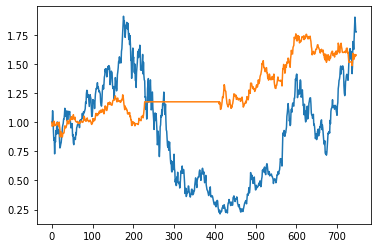

In [5]:
plt.plot(np.append(1, np.cumprod(1+gross_returns)))
plt.plot(np.append(1, np.cumprod(1+excess_returns)))